In [1]:
import cv2
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import sklearn


## Carga de archivo de Imagen

In [2]:
R_1 = cv2.imread('ImagenRetina1.tif', cv2.IMREAD_GRAYSCALE)
R_2 = cv2.imread('ImagenRetina2.tif', cv2.IMREAD_GRAYSCALE)
R_3 = cv2.imread('ImagenRetina3.tif', cv2.IMREAD_GRAYSCALE)
R_4 = cv2.imread('ImagenRetina4.tif', cv2.IMREAD_GRAYSCALE)

print(R_1.shape)


(1024, 1024)


In [3]:
Totalrecortes1= 11296


Totalrecortes2= 7182

## STACK VERTICAL IMAGENES

In [4]:
nro_recorte = 0
ApiladoCapa = None

etiquetas=[]

for nro_recorte in range(Totalrecortes1):
    
    LecturaG=cv2.imread("C:/Users/toto_/PYTHON/CapaG/G" + str(nro_recorte) + ".png", cv2.IMREAD_GRAYSCALE)
    etiquetas=np.append(etiquetas,0)
         
    if ApiladoCapa is None:
        
        #ApiladoCapa= np.array([LecturaG]) #Genera una lista , que para np es una nueva dimension tendria 1x11x11
        ApiladoCapa= LecturaG[np.newaxis,:,:] #Agrega un eje temporal en la ultima dimensión
        print (ApiladoCapa.shape)        
        
    else:
        #ApiladoCapa= np.vstack((ApiladoCapa,np.array([LecturaG])))
        
        #ApiladoCapa= np.append(ApiladoCapa,LecturaG[:,:,np.newaxis],axis=-1)
        ApiladoCapa= np.append(ApiladoCapa,LecturaG[np.newaxis,:,:],axis=0)
          
    nro_recorte += 1
    
    
nro_recorte = 0

for nro_recorte in range(Totalrecortes2): 
    
    LecturaF=cv2.imread("C:/Users/toto_/PYTHON/CapaF/F" + str(nro_recorte) + ".png", cv2.IMREAD_GRAYSCALE) 
    etiquetas=np.append(etiquetas,1)
    
    #ApiladoCapa= np.append(ApiladoCapa,LecturaF[:,:,np.newaxis],axis=-1)
    ApiladoCapa= np.append(ApiladoCapa,LecturaF[np.newaxis,:,:],axis=0)
    
    nro_recorte += 1

print(etiquetas)

(1, 15, 15)
[0. 0. 0. ... 1. 1. 1.]


In [5]:
X = ApiladoCapa
print(ApiladoCapa.shape)
Y = etiquetas
print(etiquetas.shape)

(18478, 15, 15)
(18478,)


In [6]:
#!pip install xgboost

In [7]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.model_selection import (RandomizedSearchCV,
                                     KFold,
                                     cross_val_score,
                                     train_test_split)


In [8]:
X_train,X_test,  Y_train, Y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.3,
                                                    shuffle = True,
                                                    stratify=Y,
                                                    random_state=123)

In [9]:
print(X_train.shape, Y_train.shape)

print(X_test.shape, Y_test.shape)


(12934, 15, 15) (12934,)
(5544, 15, 15) (5544,)


## Red neuronal convolucional 

In [10]:
#Convierte un vector de clase (enteros) en una matriz de clase binaria ONE-HOT.
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)

In [11]:
from PIL import Image

def rotacion(imagen, angulo):
    imagen = Image.fromarray(imagen)
    imagen_rotada = imagen.rotate(angle = angulo, expand = False)
    return np.array(imagen_rotada)

In [12]:
import random
from PIL import Image

def ruido(image,prob): 
#agregar ruido salt and pepper noise a una imagen 
#prob=probabilidad del ruido 
    output = np.zeros(image.shape,np.uint8)   
    for i in range(image.shape[0]): 
        for j in range(image.shape[1]): 
            rdn = random.random() #devuelve flotante entre 0. y 1.
            if rdn < prob: 
                output[i][j] = 0 
            elif rdn > (1-prob): 
                output[i][j] = 255 
            else: 
                output[i][j] = image[i][j] 
    return output 

In [13]:
def gamma(imagen,gamma):
    #función que dada una imagen (arreglo de tipo uint8), y un valor positivo gamma
    #devuelve otra del mismo tipo pero con ajute gamma, si gamma>1, más oscura y si gamma <1 más clara
    imagenresultado=255*((imagen/255)**gamma)
    imagenresultado=imagenresultado.astype('uint8')
    return imagenresultado

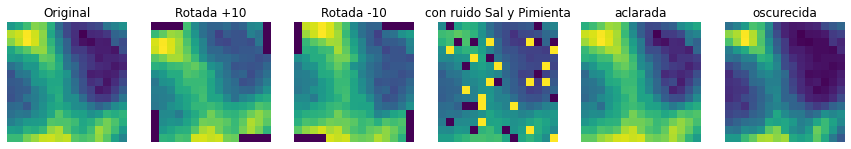

(15, 15)


In [14]:
fig, ax = plt.subplots(1, 6, figsize = (15, 30))

ax[0].imshow(X_train[0]);
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(rotacion(X_train[0], 10));
ax[1].axis('off')
ax[1].set_title('Rotada +10')

ax[2].imshow(rotacion(X_train[0], -10));
ax[2].axis('off')
ax[2].set_title('Rotada -10')

ax[3].imshow(ruido(X_train[0], 0.05));
ax[3].axis('off')
ax[3].set_title('con ruido Sal y Pimienta')

ax[4].imshow(gamma(X_train[0], 0.5));
ax[4].axis('off')
ax[4].set_title('aclarada')

ax[5].imshow(gamma(X_train[0], 2));
ax[5].axis('off')
ax[5].set_title('oscurecida')


plt.show()

print(rotacion(X_train[0], 5).shape)

In [15]:
def aumentacion(imagenes, etiquetass):
    lista_imagenes = []
    lista_etiquetas = []
    
    for i in range(imagenes.shape[0]):
        imagen, etiqueta = imagenes[i], etiquetass[i]

        lista_imagenes.append(imagen)
        lista_etiquetas.append(etiqueta)

        lista_imagenes.append(rotacion(imagen, 5))
        lista_etiquetas.append(etiqueta)    

        lista_imagenes.append(rotacion(imagen, -5))
        lista_etiquetas.append(etiqueta)
        
        lista_imagenes.append(rotacion(imagen, 10))
        lista_etiquetas.append(etiqueta)    

        lista_imagenes.append(rotacion(imagen, -10))
        lista_etiquetas.append(etiqueta)
        
        lista_imagenes.append(gamma(imagen, 0.5))
        lista_etiquetas.append(etiqueta)
        
        lista_imagenes.append(gamma(imagen, 2))
        lista_etiquetas.append(etiqueta)

        
    list_aux = list(zip(lista_imagenes, lista_etiquetas))
    #aqui guarda las imagenes y al lado su etiqueta

    random.shuffle(list_aux)
    #el shuffle sirve para desordenar los datos y no queden consecutivamente 3 etiquetas iguales seguidas(de la normal y las dos rotaciones)

    lista_imagenes, lista_etiquetas = zip(*list_aux)
    #anzip, osea despego las listas por asi decirlo
    
    return np.asarray(lista_imagenes), np.asarray(lista_etiquetas)
#me devuelve las dos listas separados

In [16]:
X_train, Y_train = aumentacion(X_train, Y_train)
X_test, Y_test = aumentacion(X_test, Y_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
#Respeta que se triplicaron los datos imagenes y lista de etiquetas

(90538, 15, 15) (90538, 2)
(38808, 15, 15) (38808, 2)


In [17]:
Imagen_de_entrada = layers.Input(shape = (15, 15, 1))

In [18]:
X = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = None, kernel_regularizer = keras.regularizers.l2(0.01))(Imagen_de_entrada)

In [19]:
X = layers.BatchNormalization()(X)
#(x) es la capa a normalizar, la cual es la capa de convolución

X = layers.Activation("relu")(X)
#Aca aplico activación luego de normalizar por eso en la capa de convolución puse NONE

In [20]:
X = layers.MaxPooling2D(pool_size = (2, 2))(X)

X = layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = None, kernel_regularizer = keras.regularizers.l2(0.01))(X)

X = layers.BatchNormalization()(X)

X = layers.Activation("relu")(X)


In [21]:
Flatten = layers.Flatten()(X)

In [22]:
X = layers.Dropout(0.7)(X)

In [23]:
X = layers.Dense(32, activation = "relu")(Flatten)

In [24]:
Salida = layers.Dense(units = 2, activation = 'sigmoid')(X)

In [25]:
Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

In [26]:
Red_Neuronal.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = 1e-5), metrics = ['accuracy'])
#Red_Neuronal.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [27]:
Historia2 = Red_Neuronal.fit(x = X_train, y = Y_train, epochs = 28, batch_size = 32, validation_data = (X_test, Y_test))

Epoch 1/28
2830/2830 [==============================] - 17s 6ms/step - loss: 0.6012 - accuracy: 0.6968 - val_loss: 0.5834 - val_accuracy: 0.7088
Epoch 2/28
2830/2830 [==============================] - 17s 6ms/step - loss: 0.5690 - accuracy: 0.7282 - val_loss: 0.5654 - val_accuracy: 0.7349
Epoch 3/28
2830/2830 [==============================] - 25s 9ms/step - loss: 0.5462 - accuracy: 0.7491 - val_loss: 0.5356 - val_accuracy: 0.7560
Epoch 4/28
2830/2830 [==============================] - 28s 10ms/step - loss: 0.5219 - accuracy: 0.7706 - val_loss: 0.5087 - val_accuracy: 0.7783
Epoch 5/28
2830/2830 [==============================] - 26s 9ms/step - loss: 0.4994 - accuracy: 0.7900 - val_loss: 0.4861 - val_accuracy: 0.7974
Epoch 6/28
2830/2830 [==============================] - 28s 10ms/step - loss: 0.4813 - accuracy: 0.8018 - val_loss: 0.4886 - val_accuracy: 0.7819
Epoch 7/28
2830/2830 [==============================] - 33s 12ms/step - loss: 0.4692 - accuracy: 0.8080 - val_loss: 0.4634 - val

In [28]:
Red_Neuronal.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 15, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 32)               

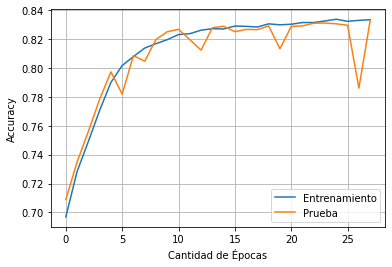

In [29]:
plt.plot(Historia2.history['accuracy'], label = 'Entrenamiento')
plt.plot(Historia2.history['val_accuracy'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

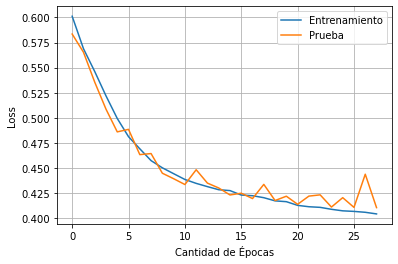

In [30]:
plt.plot(Historia2.history['loss'], label = 'Entrenamiento')
plt.plot(Historia2.history['val_loss'], label = 'Prueba')
plt.grid()
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 